# Reaction-diffusion systems 2

This notebook integrates the Schnakenberg model for pattern formation numerically. 
Integration with an explicit method, which is more straightworward, did not work in this case (probably numerically unstable), at least for me. Therefore we will use an implicit method here. For explanations about the integration methods, see the Notebook "8_PDEs_SwiftHohenberg" in the homework. This example is more complicated as it has 2 concentrations. For reasons of what the used functions require, this notebook moves back and forth between representing the concentration as two matrices (NxN for N gridpoints), each matrix entry is the concentration of one species at one grid point) and representing both as one large vector (length 2 N^2). Maybe there are more elegant ways of doing this, but it works.

In [1]:
import numpy as np
from scipy.ndimage.filters import convolve
from scipy.optimize import root
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

In [2]:
N = 200
side_length = 200
h = side_length / N

In [3]:
laplace = 1/(h**2) * np.array([
    [0, 1, 0],
    [1,-4, 1],
    [0, 1, 0]
])

### Reaction and diffusion parts of the dynamics

we define the reaction first:

In [4]:
#Schnakenberg model

#parameters
a1=0.1; a2=1; a3= 1; a4=0.9;  # use a1=0.1; a2=1; a3= 1; a4=0.9;  and D_u=1;D_v=40 below

def reaction_rhs_u(u,v):
    return a1 - a2 * u + a3 * u*u*v

def reaction_rhs_v(u,v):
    return a4 - a3 * u*u*v

and now the diffusion part and putting all together 

(we need to represent the concentration fields u and v as a single vector utot for the implicit integration, thsi is needed for the root finding command used in it and makes the code below a bit messy swicthing between different representations of the concentration fields)

In [5]:
#parameters
D_u=1;D_v=40;

def diff_rhs(u):
    u_sq = u.reshape(N,N) 
    return convolve(u_sq, laplace, mode='wrap').flatten()

def react_diff_u(u, v, dt):
    return u + dt *reaction_rhs_u(u,v) + dt * D_u * diff_rhs(u)

def react_diff_v(u, v, dt):
    return u + dt *reaction_rhs_v(u,v) + dt * D_v * diff_rhs(u)

In [6]:
D_u=1;D_v=40

def rhs(utot):
    u= utot[:N*N]
    v= utot[N*N:]
    u_sq = u.reshape(N,N)
    v_sq =v.reshape(N,N)
    
    du= reaction_rhs_u(u,v) + D_u*convolve(u_sq, laplace, mode='wrap').flatten()
    dv =reaction_rhs_v(u,v) + D_v*convolve(v_sq, laplace, mode='wrap').flatten()
    return np.concatenate((du,dv))

def rk_diff_implicit(u_new, u_old, dt):
    return u_new - u_old - dt * rhs(u_new)

let's perturb the homogeneous steady-state solution. We first calculate the steady state numerically

In [7]:
def reaction(x):
    return [reaction_rhs_u(x[0],x[1]),reaction_rhs_v(x[0],x[1])]

sol = root(reaction, [1, 1])
sol

    fjac: array([[-0.4472136 ,  0.89442719],
       [-0.89442719, -0.4472136 ]])
     fun: array([0., 0.])
 message: 'The solution converged.'
    nfev: 5
     qtf: array([2.92690777e-13, 9.75635914e-14])
       r: array([-2.236068  , -1.34164079, -0.44721359])
  status: 1
 success: True
       x: array([1. , 0.9])

and then perturb it with random noise

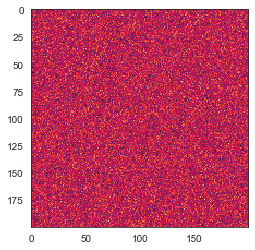

In [8]:
u = sol.x[0] + 0.5*np.random.normal(0, .01, N*N)
v = sol.x[1] + 0.5*np.random.normal(0, .01, N*N)

#u[2000]=u[2000]+10
#u[:N]+=.1

plt.imshow(u.reshape(N,N));

### random perturbation

we first perturb the homogeneous solution with random noise and integrate it

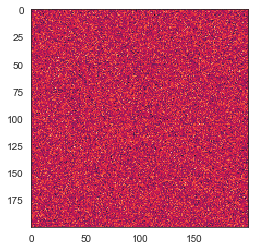

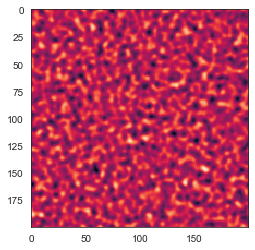

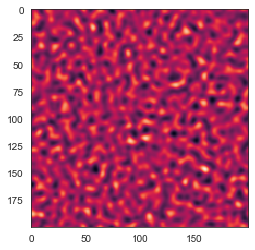

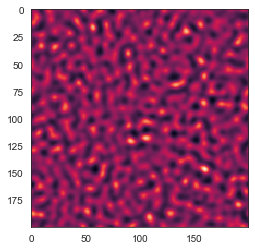

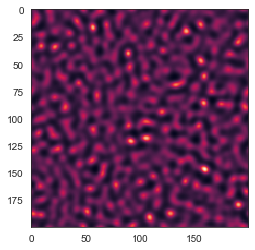

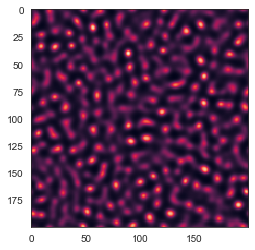

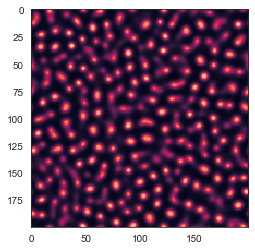

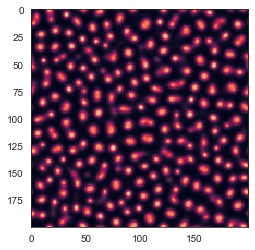

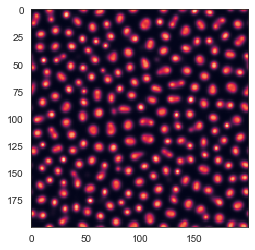

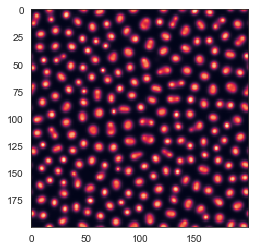

In [18]:
t = 0
dt = 1e-3
t_output = np.linspace(0, 20, 10)

u = sol.x[0] + np.random.normal(0, .05, N*N)
v = sol.x[1] + np.random.normal(0, .05, N*N)

utot=np.concatenate((u,v))

for t_next in t_output:
    while t < t_next:
        utot = root(rk_diff_implicit, utot, args=(utot,dt), method='krylov').x
        t+=dt
    uplot=utot[:N*N]
    plt.figure()
    plt.imshow(uplot.reshape(N,N))
    plt.show()

### Line perturbation

Now we perturb the homogeneous solution on a line to obtain a spreading pattern

(note the periodic boundary conditions)

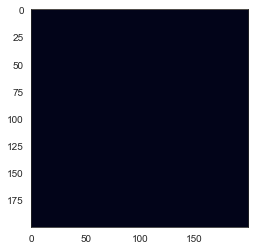

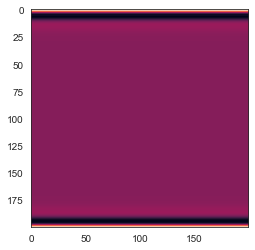

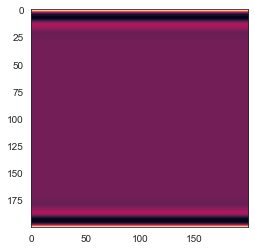

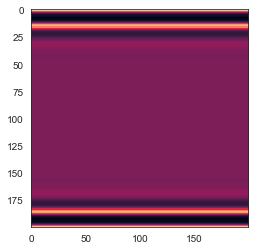

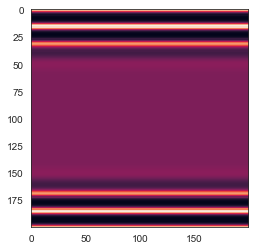

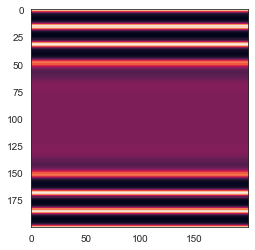

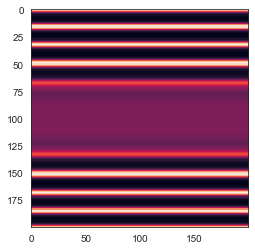

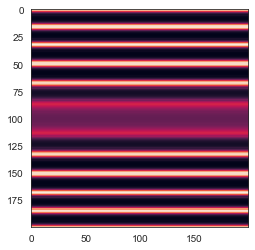

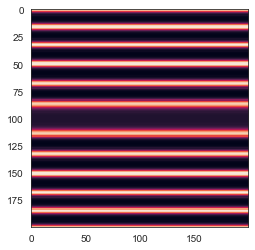

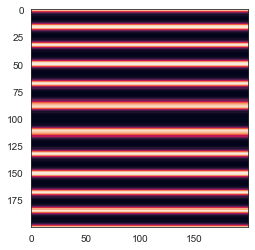

In [17]:
t = 0
dt = 1e-3
t_output = np.linspace(0, 50, 10)

u = sol.x[0] + 0*np.random.normal(0, .05, N*N)
v = sol.x[1] + 0*np.random.normal(0, .05, N*N)

u[:N]+=.1



utot=np.concatenate((u,v))
#utot[20000]+= 1

for t_next in t_output:
    while t < t_next:
        utot = root(rk_diff_implicit, utot, args=(utot,dt), method='krylov').x
        t+=dt
    uplot=utot[:N*N]
    plt.figure()
    plt.imshow(uplot.reshape(N,N))
    plt.show()

### Point perturbation

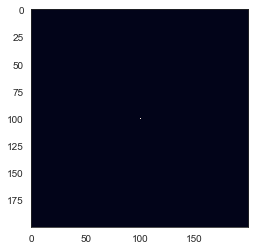

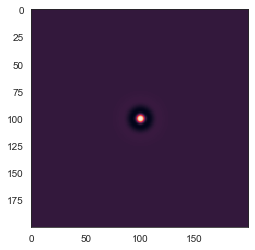

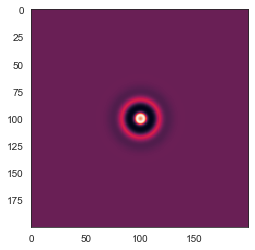

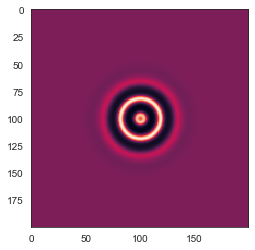

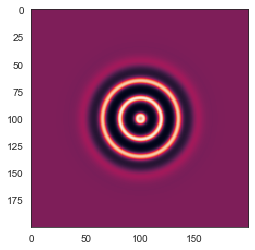

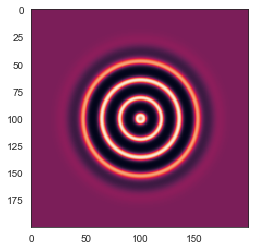

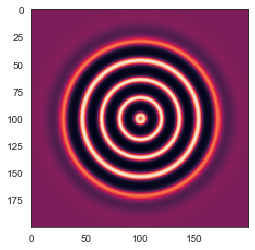

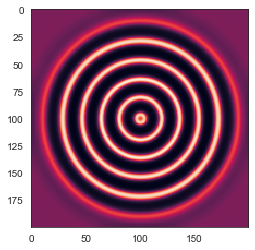

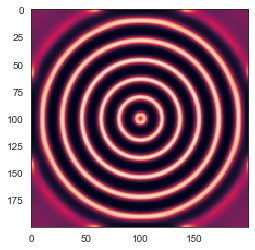

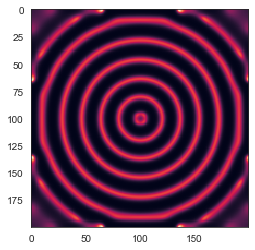

In [30]:
t = 0
dt = 1e-3
t_output = np.linspace(0, 50, 10)

u = sol.x[0] + 0*np.random.normal(0, .05, N*N)
v = sol.x[1] + 0*np.random.normal(0, .05, N*N)

u[20100]+=10



utot=np.concatenate((u,v))
#utot[20000]+= 1

for t_next in t_output:
    while t < t_next:
        utot = root(rk_diff_implicit, utot, args=(utot,dt), method='krylov').x
        t+=dt
    uplot=utot[:N*N]
    plt.figure()
    plt.imshow(uplot.reshape(N,N))
    plt.show()

In [ ]:
t = 0
dt = 1e-4
t_output = np.linspace(0, 1, 5)

for t_next in t_output:
    while t < t_next:
        u = react_diff_u(u,v,dt)
        v = react_diff_v(u,v,dt)
        t += dt
        
plt.figure()
plt.imshow(u.reshape(N,N))
plt.show()